In [ ]:
# https://www.ioiogoo.cn/2018/05/31/%e4%bd%bf%e7%94%a8k-means%e5%8f%8atf-idf%e7%ae%97%e6%b3%95%e5%af%b9%e4%b8%ad%e6%96%87%e6%96%87%e6%9c%ac%e8%81%9a%e7%b1%bb%e5%b9%b6%e5%8f%af%e8%a7%86%e5%8c%96/

In [ ]:
# -*- coding: utf-8 -*-
# file: data_utils.py
# author: apollo2mars <apollo2mars@gmail.com>

import os
import pickle
import numpy as np


class Tokenizer(object):
	""" Tokenizer for Machine Reading Comprehension

	1. Input : max length of context
	2. Get vocabulary dict : self.word2idx and self.idx2word
	3. Get Embedding Matrix
		if embedding matrix exits, load from exit file
		else build new embedding matrix
	"""

	def __init__(self, origin_text, max_seq_len, emb_dim, lower, emb_type, dat_fname, fname):
		self.origin_text = origin_text
		self.max_seq_len = max_seq_len
		self.emb_dim = emb_dim
		self.lower = lower
		self.emb_type = emb_type
		self.path_1 = dat_fname
		self.path_2 = fname

		self.word2idx = {}
		self.idx2word = {}
		self.vocab_embed = []

		self.embedding_info = Tokenizer.__embedding_info()
		self.__load_embedding(word2idx=self.word2idx, emb_dim=self.emb_dim, dat_fname=self.path_1, fname=self.path_2)
		self.__set_vocabulary(self.origin_text)
		self.__encode_vocab()

	@staticmethod
	def __embedding_info():
		embedding_files = {
			'Static':{
				"Word2Vec":"",
				"Glove":"",
				"Tencent":""},
			'Dynamic':{
				"BERT":"",
				"ELMo":"",
				"ERINE":"",
				"GPT-2-Chinese":"",
				"BERT-WWW":""}
		}

		return embedding_files

	def __load_embedding(self, word2idx, emb_dim, dat_fname, fname):
		if os.path.exists(dat_fname):
			embedding_matrix = pickle.load(open(dat_fname, 'rb'))
		else:
			embedding_matrix = np.zeros((len(word2idx) + 2, emb_dim))  # idx 0 and len(word2idx)+1 are all-zeros
			word_vec = Tokenizer.__get_vocabulary_embedding_vector_list(fname, word2idx=word2idx)
			for word, i in word2idx.items():
				embedding_matrix[i] = word_vec[word]
			pickle.dump(embedding_matrix, open(dat_fname, 'wb'))

		self.embedding_matrix = embedding_matrix

	def __set_vocabulary(self, input_text):
		"""
		:param text: text for generate vocabulary
		:return: null
		"""
		if self.lower:
			tmp_text = input_text.lower()

		from collections import Counter
		count = Counter(tmp_text)

		for idx, item in enumerate(count):
			self.word2idx[item] = idx + 1  # must + 1
			self.idx2word[idx + 1] = item

	def __encode_vocab(self, input_path, word2idx=None):
		"""
		:param input_path: staic embedding file, for example("Glove.5b.300d")
				, [0.2,0.6,..,0.2]
				Apple [0.3,0.3,..,0.7]
				Bob [0.3,0.4,..,0.7]
				Car [0.5,0.4,..,0.7]
				Do [0.8,0.4,..,0.7]
				Eat [0.9,0.4,..,0.7]
				...
				Zip [0.3,0.6,..,0.7]
		:param word2idx: vocabulary for current task  [list]
				input file : Bob Eat Apple
				[Apple, Eat, Apple]
		:return: embedding vector list for vocabury
				[[0.3,0.4,..,0.7]
				[0.9,0.4,..,0.7]
				[0.3,0.3,..,0.7]]

		get embeddding vector list from embedding matrix by vovabulary

		"""
		fin = open(input_path, 'r', encoding='utf-8', newline='\n', errors='ignore')
		word_vec = {}
		for line in fin:
			tokens = line.rstrip().split(' ')
			if word2idx is None or tokens[0] in word2idx.keys():
				word_vec[tokens[0]] = np.asarray(tokens[1:], dtype='float32')

		self.vocab_embed = word_vec

	@classmethod
	def __pad_and_truncate(cls, sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
		x = (np.ones(maxlen) * value).astype(dtype)

		if truncating == 'pre':
			trunc = sequence[-maxlen:]
		else:
			trunc = sequence[:maxlen]
			trunc = np.asarray(trunc, dtype=dtype)
		if padding == 'post':
			x[:len(trunc)] = trunc
		else:
			x[-len(trunc):] = trunc
		return x

	def encode(self, text, reverse=False, padding='post', truncating='post'):
		"""
		convert text to numberical gigital features with max length, paddding
		and truncating
		"""
		if self.lower:
			text = text.lower()
		words = list(text)
		unknown_idx = len(self.word2idx)+1
		sequence = [self.word2idx[w] if w in self.word2idx else unknown_idx for w in words]
		if len(sequence) == 0:
			sequence = [0]
		if reverse:
			sequence = sequence[::-1]

		return Tokenizer.__pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from data_utils import *
import jieba
import matplotlib.pyplot as plt

In [5]:
# bigram分词
# segment_bigram = lambda text: " ".join([word + text[idx + 1] for idx, word in enumerate(text) if idx &lt; len(text) - 1])
# 结巴中文分词
segment_jieba = lambda text: " ".join(jieba.cut(text))
 
'''
    1、加载语料
'''
corpus = []
with open("demo.txt", "r", encoding="utf-8") as f:
    for line in f:
        # 去掉标点符号
        corpus.append(segment_jieba(line.strip()))
 

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/ph/31crq1pj14n9pcl2xffj45j8t0c5l2/T/jieba.cache
Loading model cost 0.998 seconds.
Prefix dict has been built succesfully.


In [6]:
'''
    2、计算tf-idf设为权重
'''
 
vectorizer = CountVectorizer()
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus))
 
''' 
    3、获取词袋模型中的所有词语特征
    如果特征数量非常多的情况下可以按照权重降维
'''
 
word = vectorizer.get_feature_names()
print("word feature length: {}".format(len(word)))
 
''' 
    4、导出权重，到这边就实现了将文字向量化的过程，矩阵中的每一行就是一个文档的向量表示
'''
tfidf_weight = tfidf.toarray()

word feature length: 736


In [11]:
'''
    5、对向量进行聚类
'''
 
# 指定分成7个类
kmeans = KMeans(n_clusters=5)
kmeans.fit(tfidf_weight)
 
# 打印出各个族的中心点
print(kmeans.cluster_centers_)
for index, label in enumerate(kmeans.labels_, 1):
    print("index: {}, label: {}".format(index, label))
 
# 样本距其最近的聚类中心的平方距离之和，用来评判分类的准确度，值越小越好
# k-means的超参数n_clusters可以通过该值来评估
print("inertia: {}".format(kmeans.inertia_))

[[ 4.55758905e-04  7.48754256e-04  6.98638572e-04 ...  4.09735761e-03
   4.34029888e-04  7.87401575e-04]
 [-1.30104261e-18  6.50521303e-19 -1.84314369e-18 ... -5.20417043e-18
   4.33680869e-19  1.84314369e-18]
 [ 1.62630326e-19 -9.75781955e-19 -9.75781955e-19 ... -3.46944695e-18
   3.79470760e-19  1.08420217e-18]
 [-8.13151629e-19 -3.25260652e-19 -1.51788304e-18 ... -4.77048956e-18
   3.79470760e-19  1.62630326e-18]
 [ 1.62630326e-19 -1.08420217e-18 -9.75781955e-19 ... -3.46944695e-18
   3.25260652e-19  1.08420217e-18]]
index: 1, label: 1
index: 2, label: 1
index: 3, label: 0
index: 4, label: 3
index: 5, label: 0
index: 6, label: 1
index: 7, label: 2
index: 8, label: 0
index: 9, label: 3
index: 10, label: 0
index: 11, label: 0
index: 12, label: 0
index: 13, label: 1
index: 14, label: 0
index: 15, label: 0
index: 16, label: 0
index: 17, label: 0
index: 18, label: 0
index: 19, label: 0
index: 20, label: 0
index: 21, label: 1
index: 22, label: 0
index: 23, label: 0
index: 24, label: 0
ind

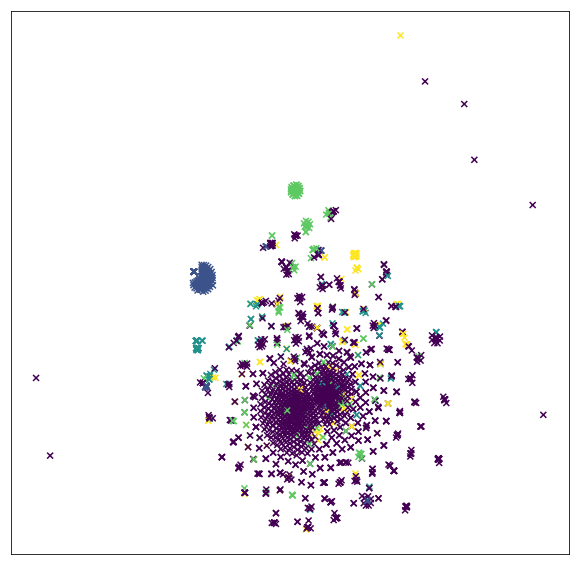

In [12]:
'''
    6、可视化
'''
 
# 使用T-SNE算法，对权重进行降维，准确度比PCA算法高，但是耗时长
tsne = TSNE(n_components=2)
decomposition_data = tsne.fit_transform(tfidf_weight)
 
x = []
y = []
 
for i in decomposition_data:
    x.append(i[0])
    y.append(i[1])
 
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.scatter(x, y, c=kmeans.labels_, marker="x")
plt.xticks(())
plt.yticks(())
# plt.show()
plt.savefig('./sample.png', aspect=1)